In [1]:
# Установка необходимых библиотек
!pip install emoji==2.14.0 optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 16.4 MB/s eta 0:00:0000:01


In [2]:
# Импорт библиотек
import matplotlib.pyplot as plt
import os
import re

from sklearn.isotonic import IsotonicRegression

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from datasets import Dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers.trainer_utils import EvalPrediction

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, classification_report, confusion_matrix

import emoji
import warnings
import optuna

warnings.filterwarnings("ignore")
os.environ["WANDB_MODE"] = "disabled"

2025-07-31 10:01:26.110882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753956086.343485      78 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753956086.405667      78 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Подгрузка модели RuModernBERT-base и токенизатора
MODEL_NAME = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Конфигурация
DATA_PATH = "/kaggle/input/datasets-lad/dataset.csv"
DATA_PATH_2 = '/kaggle/input/datasets-lad/gpt_message_label_1.csv'

In [5]:
def preprocess_text(text: str) -> str:
    """Предобрабатывает текст для анализа моделью.

    Выполняет очистку текста: удаляет URL, код, HTML-теги, эмодзи, лишние символы,
    сохраняет строки с русским текстом, приводит к нижнему регистру.

    Args:
        text (str): Входной текст для обработки.

    Returns:
        str: Предобработанный текст. Возвращает пустую строку, если текст пустой
             или содержит только пунктуацию.
    """
    # Проверка типа входного текста
    if not isinstance(text, str):
        return ""

    # Компиляция паттерна для удаления URL
    url_pattern = re.compile(r"https?://\S+|www\.\S+")

    # Определение паттернов для удаления кода
    code_patterns = [
        r'```[\s\S]*?```',  # Блоки кода в тройных кавычках
        r'<[^>]+>[\s\S]*?</[^>]+>',  # HTML-теги
        r'\b(def|function|class|import|from|if|else|elif|for|while|return|try|except|async|await)\b[^{а-яА-Я]*[;\n]',  # Ключевые слова
        r'(?<!\w)[A-Za-z_][A-Za-z0-9_]*\s*=\s*[^{а-яА-Я]+?(?=[\s\n]|$)',  # Присваивания
        r'(?<!\w)[A-Za-z_][A-Za-z0-9_]*\.[A-Za-z_][A-Za-z0-9_]*\([^{а-яА-Я]*\)',  # Вызовы методов
        r'(?<!\w)[A-Za-z_][A-Za-z0-9_]*\([^{а-яА-Я]*\)',  # Функции
        r'(?<!\w)[A-Z]+\b(?:\.[A-Z]+)*\([^{а-яА-Я]*\)'  # Константы
    ]

    # Временная замена скобок с русским текстом
    placeholder = "§§§§§"
    brackets_with_russian = re.compile(r'([(\[{])(?=[^])}]*[а-яА-Я])(.*?)([)\]}])')
    preserved = []

    def save_brackets(match):
        """Сохраняет скобки с русским текстом, заменяя их на placeholder."""
        preserved.append(match.group(0))
        return placeholder

    # Замена скобок с русским текстом на placeholder
    text = brackets_with_russian.sub(save_brackets, text)

    # Удаление кода по каждому паттерну
    for pattern in code_patterns:
        text = re.sub(pattern, "", text, flags=re.MULTILINE)

    # Удаление скобочных конструкций БЕЗ русских букв
    text = re.sub(r'\([^()]*[а-яА-Я][^()]*\)', '', text)  # сохраняем скобки с русским текстом
    text = re.sub(r'\([^()]*\)', '', text)  # удаляем оставшиеся скобки
    text = re.sub(r'\{[^{}]*\}', '', text)
    text = re.sub(r'\[[^\[\]]*\]', '', text)

    # Восстановление сохраненных скобок с русским текстом
    for item in preserved:
        text = text.replace(placeholder, item, 1)

    # Удаление строк без русских букв
    lines = text.split('\n')
    processed_lines = []
    for line in lines:
        if re.search('[а-яА-Я]', line):
            processed_lines.append(line)
        elif not line.strip():
            processed_lines.append('')
            
    text = "\n".join(processed_lines)

    # Замена переносов строк, табуляций и множественных пробелов
    text = re.sub(r"[\n\r\t]", " ", text)
    # Удаление специальных символов
    text = re.sub(r"[•▪★✔►–—«»…]", "", text)
    # Нормализация повторяющихся знаков препинания
    text = re.sub(r"([!?])\1+", r"\1", text)
    # Замена неразрывных пробелов и нулевых пробелов
    text = text.replace(u"\xa0", " ").replace(u"\u200b", "")
    # Удаление эмодзи
    text = emoji.replace_emoji(text, replace="")
    # Удаление лишних пробелов и обрезка
    text = re.sub(r"\s+", " ", text).strip()
    # Удаление URL
    text = url_pattern.sub('', text)
    # Приведение к нижнему регистру
    text = text.lower()

    # Проверка на пустой текст или текст только из пунктуации
    if not text or re.match(r"^[.!?,;:]+$", text):
        return ""
    return text

In [6]:
from sklearn.isotonic import IsotonicRegression
def calibrate_probs(probs, labels):
    """
    Калибровка вероятностей с использованием изотонической регрессии.
    
    Args:
    probs: Предсказанные вероятности.
    labels: Истинные метки.

    Returns:
    Откалиброванные вероятности.
    """
    # инициализация изотонической регрессии
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    # Обучение модели
    iso_reg.fit(probs.reshape(-1, 1), labels)
    # предсказание откалиброванных вероятностей
    return iso_reg.predict(probs.reshape(-1, 1))

In [7]:
def find_best_threshold(y_true, y_probs, plot=False):
    """
    Находит оптимальный порог для классификации при recall = 1.
    
    Args:
    y_true: Истинные метки.
    y_probs: Предсказанные вероятности.
    plot: Флаг для отображения графика PR-кривой.

    Returns:
    best_threshold: Оптимальный порог.
    best_precision: Точность при оптимальном пороге.
    """
    # вычисление PR-кривой
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    best_threshold = 0.0
    best_precision = 0.0
    for p, r, t in zip(precision, recall, thresholds):
        if r == 1 and p > best_precision:
            best_precision = p
            best_threshold = t
    
    # построение графика PR-кривой        
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, label='PR-curve')
        plt.axvline(x=1, color='red', linestyle='--', label='Recall=1')
        plt.scatter([recall[np.argmax((recall == 1) & (precision == best_precision))]],
                    [best_precision], color='green', label=f'Best precision={best_precision:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return best_threshold, best_precision

In [8]:
# Метрики
def compute_metrics(p: EvalPrediction):
    """
    Args:
    p: Объект EvalPrediction с предсказаниями и метками.

    Returns:
    Словарь с метриками точности и полноты.
    """
    # преобразование предсказаний в вероятности
    preds = torch.sigmoid(torch.tensor(p.predictions)).numpy().squeeze()
    # истинные метки
    labels = p.label_ids
    # бинаризация предсказаний
    preds_binary = (preds >= 0.5).astype(int)
    return {
        "precision": precision_score(labels, preds_binary),
        "recall": recall_score(labels, preds_binary),
    }

In [9]:
def predict_and_optimize(model, dataset, y_true, val_texts):
    """
    Выполняет предсказания на валидационной выборке и оптимизирует порог классификации.

    Args:
    model: Обученная модель.
    dataset: Валидационный датасет.
    y_true: Истинные метки.
    val_texts: Тексты валидационной выборки.

    Returns:
    val_probs: Откалиброванные вероятности.
    best_thresh: Оптимальный порог.
    best_prec: Точность при оптимальном пороге.
    """
    # перенос модели на GPU
    model.to('cuda')
    # перевод модели в режим оценки
    model.eval()
    # создание загрузчика данных
    loader = torch.utils.data.DataLoader(dataset, batch_size=16)
    all_probs = []
    # отключение вычисления градиентов
    with torch.no_grad():
        for batch in loader:
            # перенос данных на GPU
            inputs = {k: v.to('cuda') for k, v in batch.items() if k != 'labels'}
            # получение предсказаний
            outputs = model(**inputs).logits.squeeze()
            # преобразование в вероятности
            probs = torch.sigmoid(outputs).cpu().numpy()
            # сохранение вероятностей
            all_probs.extend(probs if probs.ndim > 0 else [probs.item()])
    
    y_probs = np.array(all_probs)
    print(f"Probs shape: {y_probs.shape}, Labels shape: {y_true.shape}")
    print(f"Sample probs: {y_probs[:5]}, Sample labels: {y_true[:5]}")
    # калибровка вероятностей
    y_probs_calibrated = calibrate_probs(y_probs, y_true)
    # поиск оптимального порога
    threshold, best_prec = find_best_threshold(y_true, y_probs_calibrated, plot=True)
    # финальные предсказания
    preds_final = (y_probs_calibrated >= threshold).astype(int)
    print("\nFinal Evaluation Report (threshold =", round(threshold, 3), ")")
    # отчет о классификации
    print(classification_report(y_true, preds_final))
    print("Confusion Matrix:")
    # матрица ошибок
    print(confusion_matrix(y_true, preds_final))
    wrong_preds = pd.DataFrame({
        'text': val_texts,
        'true': y_true,
        'pred': preds_final,
        'prob': y_probs_calibrated
    })
    print("\nWrong predictions (false positives & false negatives):")
    # ошибочные предсказания
    print(wrong_preds[wrong_preds['true'] != wrong_preds['pred']].head(100))
    return y_probs_calibrated, threshold, best_prec

In [10]:
def prepare_data(df):
    """
    Подготавливает данные для обучения модели.

    Args:
    df: Исходный датафрейм с текстами и метками.

    Returns:
    train_dataset: Обучающий датасет.
    val_dataset: Валидационный датасет.
    full_dataset: Полный датасет.
    max_length: Максимальная длина токенов.
    val_texts: Тексты валидационной выборки.
    val_labels: Метки валидационной выборки.
    """
    # предобработка текстов
    df["text"] = df["text"].apply(preprocess_text)
    # удаление пропущенных значений
    df = df.dropna(subset=["text", "label"])
    # удаление дубликатов
    df = df.drop_duplicates(subset=["text", "label"], keep="first")
    # вычисление длин токенов
    lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in df['text']]
    # определение максимальной длины
    max_length = int(np.percentile(lengths, 95))
    print(f"Оптимальная длина токенов: {max_length}")
    # Разделение данных на обучающую и валидационную выборки
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    val_texts = val_df['text'].tolist()
    val_labels = val_df['label'].astype(float).tolist()
    full_dataset = Dataset.from_pandas(df)
    
    def process_examples(examples):
        """
        Токенизация текстов и преобразование меток.
        """
        tokenized = tokenizer(
            examples["text"],
            truncation=True,
            padding=True,
            max_length=max_length
        )
        tokenized["labels"] = torch.tensor(examples["label"], dtype=torch.float)
        return tokenized
        
    # токенизация полного датасета    
    full_dataset = full_dataset.map(process_examples, batched=True)
    full_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    # токенизация обучающего датасета
    train_dataset = Dataset.from_pandas(train_df).map(process_examples, batched=True)
    # токенизация валидационного датасета
    val_dataset = Dataset.from_pandas(val_df).map(process_examples, batched=True)
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return train_dataset, val_dataset, full_dataset, max_length, val_texts, val_labels

In [11]:
class CustomTrainer(Trainer):
    """
    Кастомный Trainer для бинарной классификации с BCEWithLogitsLoss.
    """
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Вычисляет потери с использованием BCEWithLogitsLoss.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if logits.dim() > 1:
            logits = logits.squeeze(-1)
        if logits.dim() == 0:
            logits = logits.unsqueeze(0)
        # функция потерь для бинарной классификации
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [12]:
def objective(trial):
    """
    Функция для оптимизации гиперпараметров с помощью Optuna.

    Args:
    trial: Объект trial Optuna.

    Returns:
    Средняя точность при кросс-валидации.
    """
    # подбор learning rate
    learning_rate = trial.suggest_float("learning_rate", 5e-6, 1e-4, log=True)
    # подбор batch size
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 2, 5)
    # подбор веса регуляризации
    weight_decay = trial.suggest_float("weight_decay", 0.001, 0.1)
    # подбор количества размороженных слоев
    num_layers_to_unfreeze = trial.suggest_int("num_layers_to_unfreeze", 0, 10)

    # инициализация стратифицированной кросс-валидации
    skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    labels = [example['labels'].item() for example in full_dataset]
    precisions = []
    
    # Цикл по фолдам кросс-валидации
    for train_index, val_index in skf.split(full_dataset, labels):
        train_subset = full_dataset.select(train_index)
        val_subset = full_dataset.select(val_index)
        
        # Инициализация модели
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
        model.to('cuda')
        
        # Управление обучением слоев
        for param in model.parameters():
            param.requires_grad = False
        if num_layers_to_unfreeze > 0:
            for layer in model.model.layers[-num_layers_to_unfreeze:]:
                for param in layer.parameters():
                    param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True
            
        # Настройка параметров обучения    
        training_args = TrainingArguments(
            output_dir=f"/kaggle/working/results_trial_{trial.number}",
            run_name=f"trial_{trial.number}",
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            eval_strategy="no",
            save_strategy="no",
            logging_strategy="no",
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            warmup_ratio=0.1,
        )

        # Инициализация тренера
        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_subset,
            eval_dataset=val_subset,
            tokenizer=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer, padding=True),
        )

        # Настройка загрузчика данных
        trainer.train_dataloader = torch.utils.data.DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=trainer.data_collator,
            drop_last=True
        )

        # Обучение модели
        trainer.train()

        # Оценка на валидационной выборке
        predictions = trainer.predict(val_subset)
        probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy().squeeze()
        y_true = predictions.label_ids

        # Вычисление PR-кривой
        precision, recall, thresholds = precision_recall_curve(y_true, probs)
        best_precision = 0.0

        # Поиск лучшей точности при полноте = 1
        for p, r in zip(precision, recall):
            if r == 1 and p > best_precision:
                best_precision = p
        precisions.append(best_precision)
        
    # Возвращаем среднюю точность по всем фолдам
    return np.mean(precisions)

In [13]:
def cross_val_evaluate(full_dataset, best_params):
    """
    Оценка модели с кросс-валидацией.

    Args:
    full_dataset: Полный датасет.
    best_params: Оптимальные гиперпараметры.

    Returns:
    Средняя точность при кросс-валидации.
    """
    # Инициализация стратифицированной K-fold кросс-валидации
    skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    labels = [example['labels'].item() for example in full_dataset]
    precisions = []

    # Цикл по фолдам
    for train_index, val_index in skf.split(full_dataset, labels):
        # Разделение на обучающую и валидационную выборки
        train_subset = full_dataset.select(train_index)
        val_subset = full_dataset.select(val_index)

        # Инициализация модели
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
        model.to('cuda')

        # Замораживание/размораживание слоев
        for param in model.parameters():
            param.requires_grad = False
        if best_params['num_layers_to_unfreeze'] > 0:
            for layer in model.model.layers[-best_params['num_layers_to_unfreeze']:]:
                for param in layer.parameters():
                    param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True

        # Настройка параметров обучения
        training_args = TrainingArguments(
            output_dir="/kaggle/working/results_cv",
            run_name="cv_run",
            num_train_epochs=best_params['num_epochs'],
            per_device_train_batch_size=best_params['batch_size'],
            per_device_eval_batch_size=best_params['batch_size'],
            eval_strategy="no", # Отключение оценки во время обучения
            save_strategy="no", # Отключение сохранения
            logging_strategy="no", # Отключение логирования
            learning_rate=best_params['learning_rate'],
            weight_decay=best_params['weight_decay'],
            warmup_ratio=0.1,
        )
        # Инициализация тренера
        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_subset,
            eval_dataset=val_subset,
            tokenizer=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer, padding=True),
        )
        # Настройка загрузчика данных
        trainer.train_dataloader = torch.utils.data.DataLoader(
            train_subset,
            batch_size=best_params['batch_size'],
            shuffle=True,
            collate_fn=trainer.data_collator,
            drop_last=True
        )
        # Обучение модели
        trainer.train()

        # Предсказание на валидационной выборке
        predictions = trainer.predict(val_subset)
        probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy().squeeze()
        y_true = predictions.label_ids

        # Вычисление метрик
        precision, recall, thresholds = precision_recall_curve(y_true, probs)
        best_precision = 0.0
        for p, r in zip(precision, recall):
            if r == 1 and p > best_precision:
                best_precision = p
        precisions.append(best_precision)
    return np.mean(precisions)

In [14]:
def inference_on_new(model, tokenizer, texts, threshold, max_length):
    """
    Выполняет предсказания на новых данных.
    
    Args:
    model: Обученная модель.
    tokenizer: Токенизатор.
    texts: Список текстов для предсказания.
    threshold: Порог классификации.
    max_length: Максимальная длина токенов.

    Returns:
    preds: Предсказанные классы.
    probs: Вероятности предсказаний.
    """
    # предобработка текстов
    texts = [preprocess_text(t) for t in texts]  
    # токенизация
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # Переключение модели в режим оценки
    model.eval()
    # Выполнение инференса без градиентов
    with torch.no_grad():
        # получение предсказаний
        outputs = model(**{k: v.to('cuda') for k, v in encodings.items()})
        # преобразование в вероятности
        probs = torch.sigmoid(outputs.logits.squeeze()).cpu().numpy()
        # бинаризация предсказаний
        preds = (probs >= threshold).astype(int)
    return preds, probs

In [15]:
def balance_dataset(df):
    """
    Балансирует датасет, уравнивая количество примеров каждого класса.

    Args:
    df: Исходный датасет.

    Returns:
    Сбалансированный датасет.
    """
    # количество положительных примеров
    n_pos = len(df[df['label'] == 1])
    # выборка отрицательных примеров
    df_neg = df[df['label'] == 0].sample(n=n_pos, random_state=42)
    # выборка положительных примеров
    df_pos = df[df['label'] == 1]
    # объединение датафреймов
    balanced_df = pd.concat([df_pos, df_neg], ignore_index=True)
    return balanced_df

In [16]:
# загрузка основного датасета
data = pd.read_csv(DATA_PATH, sep=';') 
# загрузка дополнительного датасета
data_aug = pd.read_csv(DATA_PATH_2, sep=";")
# объединение датасетов
df = pd.DataFrame({"text": data['text'].tolist() + data_aug['text'].tolist(), "label": data['label'].tolist() + data_aug['label'].tolist()})

In [17]:
# Вывод информации о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4214 entries, 0 to 4213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4214 non-null   object
 1   label   4214 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 66.0+ KB


In [18]:
# Балансировка датасета
df = balance_dataset(df)

In [19]:
# Проверка баланса классов
df['label'].value_counts()

label
1    1709
0    1709
Name: count, dtype: int64

In [20]:
# Подготовка данных
train_dataset, val_dataset, full_dataset, max_length, val_texts, val_labels = prepare_data(df)

Оптимальная длина токенов: 76


Map:   0%|          | 0/3336 [00:00<?, ? examples/s]

Map:   0%|          | 0/2668 [00:00<?, ? examples/s]

Map:   0%|          | 0/668 [00:00<?, ? examples/s]

In [21]:
# Проверка размеров датасетов
print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Sample labels:", train_dataset['labels'][:5], val_dataset['labels'][:5])

Train dataset size: 2668
Val dataset size: 668
Sample labels: tensor([0., 1., 0., 0., 0.]) tensor([0., 1., 1., 1., 1.])


In [22]:
# Запуск Optuna
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=20)
#best_params = study.best_params
#print("Best hyperparameters:", best_params)

In [23]:
# параметры после Optuna (сохранила, чтобы не перезапускать поиск)
best_params = {'learning_rate': 3.678376241390165e-05, 'batch_size': 32, 'num_epochs': 4, 'weight_decay': 0.02904037755747972, 'num_layers_to_unfreeze': 7}

In [24]:
# Финальная оценка с кросс-валидацией
final_precision = cross_val_evaluate(full_dataset, best_params)
print(f"Cross-validated precision: {final_precision}")

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Cross-validated precision: 0.8906742616302695


In [25]:
# Обучение финальной модели
def train_model(train_dataset, val_dataset, best_params):
    """
    Обучает финальную модель с оптимальными гиперпараметрами.
    
    Args:
        train_dataset: Обучающий датасет
        val_dataset: Валидационный датасет для оценки
        best_params: Словарь с оптимальными гиперпараметрами
        
    Returns:
        Обученная модель
    """
    # Инициализация модели
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
    # Перенос модели на GPU
    model.to('cuda')
    # Замораживаем все слои модели
    for param in model.parameters():
        param.requires_grad = False
    
    # Размораживаем указанное количество последних слоев
    if best_params['num_layers_to_unfreeze'] > 0:
        for layer in model.model.layers[-best_params['num_layers_to_unfreeze']:]:
            for param in layer.parameters():
                param.requires_grad = True

    # Всегда размораживаем классификатор    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    # Настройка параметров обучения
    training_args = TrainingArguments(
        output_dir="/kaggle/working/results_final", # Директория для сохранения
        run_name="final_run", # Имя запуска
        num_train_epochs=best_params['num_epochs'], # Количество эпох
        per_device_train_batch_size=best_params['batch_size'],  # Размер батча
        per_device_eval_batch_size=best_params['batch_size'], # Размер батча для оценки
        eval_strategy="epoch", # Оценка после каждой эпохи
        save_strategy="epoch",  # Сохранение после каждой эпохи
        logging_strategy="no", # Отключение логирования
        learning_rate=best_params['learning_rate'], # Скорость обучения
        weight_decay=best_params['weight_decay'],  # Коэффициент L2-регуляризации
        warmup_ratio=0.1, # Прогрев обучения
        load_best_model_at_end=True, # Загрузка лучшей модели в конце
        metric_for_best_model="eval_loss",  # Метрика для выбора лучшей модели
    )

    # Инициализация кастомного тренера
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics, # Функция для вычисления метрик
        data_collator=DataCollatorWithPadding(tokenizer, padding=True),  # Коллатор для батчей
    )

    # Запуск обучения
    trainer.train()
    return model

final_model = train_model(train_dataset, val_dataset, best_params)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at deepvk/RuModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall
1,No log,0.073897,0.984709,0.966967
2,No log,0.051265,0.973214,0.981982
3,No log,0.054944,0.973529,0.993994
4,No log,0.054963,0.976261,0.987988


Probs shape: (668,), Labels shape: (668,)
Sample probs: [9.5512598e-07 9.9971157e-01 9.9429566e-01 9.9998868e-01 9.9998629e-01], Sample labels: [0. 1. 1. 1. 1.]


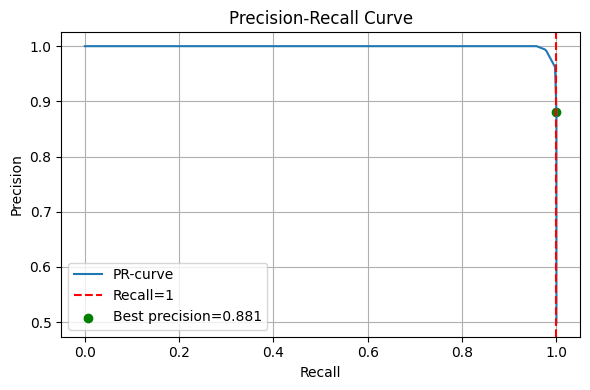


Final Evaluation Report (threshold = 0.03 )
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93       335
         1.0       0.88      1.00      0.94       333

    accuracy                           0.93       668
   macro avg       0.94      0.93      0.93       668
weighted avg       0.94      0.93      0.93       668

Confusion Matrix:
[[290  45]
 [  0 333]]

Wrong predictions (false positives & false negatives):
                                                  text  true  pred      prob
30   кто то настраивал вебхук на получение сообщени...   0.0     1  0.030303
67                               как у youtube не знаю   0.0     1  0.030303
78   навык первый: уметь продать свои услуги. навык...   0.0     1  0.030303
93            как можно оптимизировать и ускорить код?   0.0     1  0.375000
100  джанго объективно лучше будет изучать. тут оче...   0.0     1  0.375000
113                            что такое subcategory ?   0.0     1  0

In [26]:
# Оценка на валидационной выборке
y_true = np.array(val_labels).astype(float)
val_probs, best_thresh, best_prec = predict_and_optimize(final_model, val_dataset, y_true, val_texts)
print(f"Best precision: {best_prec}, Best threshold: {best_thresh}")

In [28]:
# Пример инференса
new_texts = [
    "Ищу на курс по Python!",
    "У меня не работает приложение",
    "Когда следующее занятие?"
]
preds, probs = inference_on_new(final_model, tokenizer, new_texts, best_thresh, max_length)
for text, pred, prob in zip(new_texts, preds, probs):
    print(f"\n{text}\n → Класс: {pred} (вероятность: {prob:.3f})")


Ищу на курс по Python!
 → Класс: 1 (вероятность: 1.000)

У меня не работает приложение
 → Класс: 0 (вероятность: 0.000)

Когда следующее занятие?
 → Класс: 0 (вероятность: 0.008)


In [29]:
# Загрузка тестовых данных
test_text = pd.read_csv('/kaggle/input/datasets-lad/test.csv', sep=';')  

In [30]:
# Инференс на тестовых данных
preds, probs = inference_on_new(final_model, tokenizer, test_text['text'], best_thresh, max_length)
for text, pred, prob in zip(test_text['text'], preds, probs):
    if pred == 1:
        print(f"\n{text}\n → Класс: {pred} (вероятность: {prob:.3f})")


Дадите совет по моей просьбе?
 → Класс: 1 (вероятность: 0.042)

Как обычно делаются такие вещи, подскажите новичку в деле
 → Класс: 1 (вероятность: 0.044)

Кто подскажет/поможет. У меня проект онлайн платформы обучения, все работает нормально, теперь нужно генерировать сертификаты для юзеров. Сейчас делал так что брал html вводил нужные данные имя юзера курс который прошел и его конвертировал в pdf. Выходит некрасиво теперь ищу другой способ. Использовал html так как нужно смотреть статус прохождения курса и выдавать что прошел или прослушал.
 → Класс: 1 (вероятность: 0.057)

Сколько лет бумаг беготни и денег на это уйдет?))
 → Класс: 1 (вероятность: 0.110)

Мржно ли устроиться в простенькую компанию не под своим именем?
 → Класс: 1 (вероятность: 0.939)

а php с Laravel я так, только начал изучать
 → Класс: 1 (вероятность: 0.037)

Привет ребята. Я ищу кто может мне помочь сделать маленький проект за деньги по Django
 → Класс: 1 (вероятность: 0.976)

кто нибудь сталкивался с такой проб

In [31]:
# Сохранение модели
final_model.save_pretrained("/kaggle/working/rumodernbert_model")
tokenizer.save_pretrained("/kaggle/working/rumodernbert_model")

('/kaggle/working/rumodernbert_model/tokenizer_config.json',
 '/kaggle/working/rumodernbert_model/special_tokens_map.json',
 '/kaggle/working/rumodernbert_model/tokenizer.json')

In [33]:
# лучший порог
best_thresh

0.030303031